---
title: "31 Million Wine Reviews"
description: "I scraped a LOT of reviews. Found neat distributions and bizarre reviewers."
author:
  - name: Stephen Ro
    url: https://royourboat.github.io/
date: 07-06-2023
categories: [Python, JSON, NLP, PostgreSQL] # self-defined categories
citation: 
  url: https://royourboat.github.io/posts/2023-07-06-vivino-part1/ 
image: 31m.png
draft: false # setting this to `true` will prevent your post from appearing on your listing page until you're ready!
footnotes-hover: true
format: 
  html:
    code-fold: true
    code-overflow: wrap
    toc: true
    code-block-background: true
    code-block-border-left: "#31BAE9"
number-sections: false
highlight-style: github
---

# Background

[Vivino](https://www.vivino.com/) is a very popular wine app containing millions of wines. Many wines have over 100k+ reviews!

I noticed approximately 0.5% (~1 in 200) of reviews contain the price a user paid and their sentiment for that price. An example of reviews with "price-sentiment" are shown in the diagram below. 

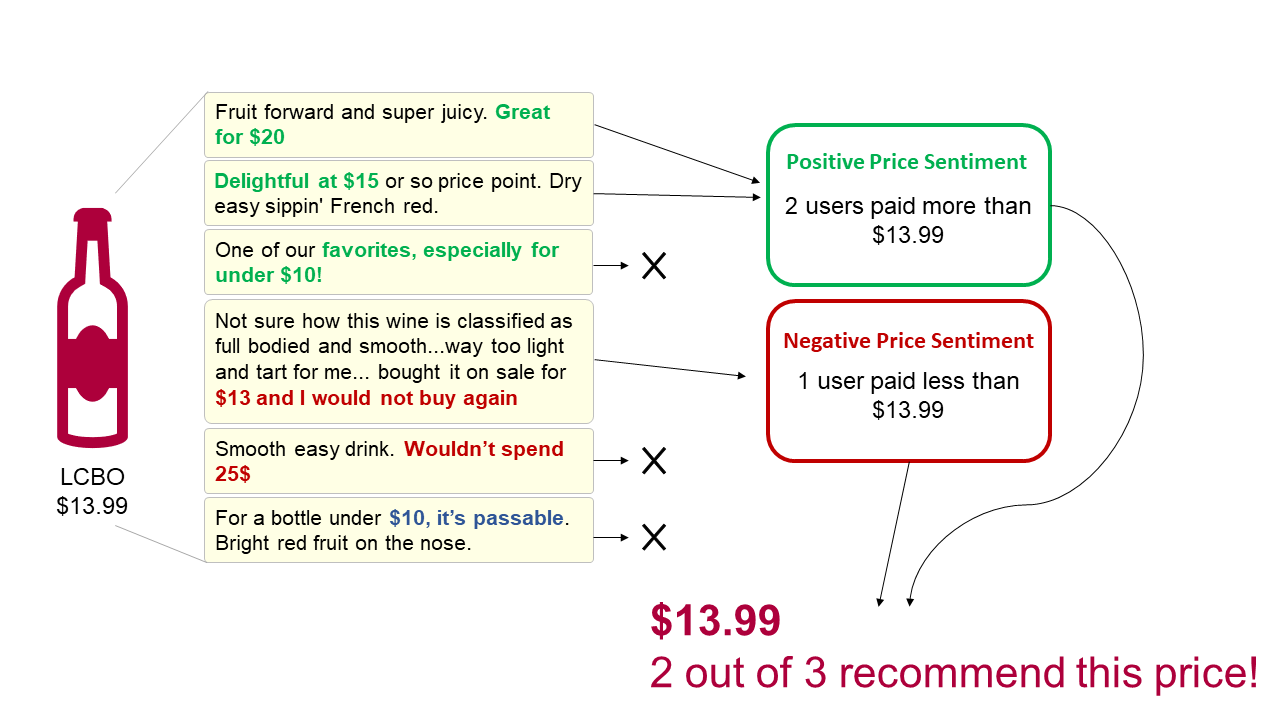


My idea is to crowdsource price-sentiments to judge whether the price of wine set by my liquor store is good or not. 

For example, suppose the LCBO (my liquor store) sells a particular bottle for $13.99. I look at all of Vivino's reviews for the bottle and find users who:

- paid <span style="font-weight:bold">more</span> than $13.99 and <span style="color:green;">liked</span> the price
- paid <span style="font-weight:bold">less</span> than $13.99 and <span style="color:red;">disliked</span> the price

This requires a large number of reviews to:

- Train a machine learning algorithm
- Decide whether a bottle has a "good" price

So, I scraped thousands of wine products from the LCBO website! I matched them to bottles on Vivino and gently downloaded about 6 million corresponding reviews. Both the LCBO and Vivino datasets are hosted on my local PostgreSQL database for fast querying. 

I continued to gently amass 31 million reviews. This blog looks at the first partition of tables consisting of 11M reviews. 

# The Reviews

## 1. Header

In [5]:
#| echo: false 
from dotenv import load_dotenv
import os
from utils import sql

load_dotenv()
sql_address = os.getenv("MYPSQLADDRESS")

In [6]:
#| code-summary: "Code: get number of reviews"
import pandas as pd

q = """
SELECT COUNT(*) as count
FROM vivino
GROUP BY vivino_id
;
"""
numReviews = sum(pd.read_sql(q, sql_address)['count'])
numWines = len(pd.read_sql(q, sql_address)['count'])

print(f"Total number of reviews: {numReviews}")
print(f"Total number of wines: {numWines}")

Total number of reviews: 11214793
Total number of wines: 12845


In [4]:
#| code-summary: "Code: get number of reviews from extras table"
import pandas as pd

q = """
SELECT COUNT(*) as count
FROM vivino_extra
GROUP BY vivino_id
;
"""
numReviews = sum(pd.read_sql(q, sql_address)['count'])
numWines = len(pd.read_sql(q, sql_address)['count'])

print("Note: From extra table not used in this analysis:")
print(f"Total number of reviews: {numReviews}")
print(f"Total number of wines: {numWines}")

Note: From extra table not used in this analysis:
Total number of reviews: 20134847
Total number of wines: 49517


In [67]:
#| tbl-cap: Features per Vivino review
#| code-summary: "Code: get SQL table features"
from IPython.display import Markdown
from tabulate import tabulate

q = """
SELECT column_name
FROM information_schema.columns
WHERE table_schema = 'public'
AND table_name   = 'vivino'
;
"""
colNames = pd.read_sql(q, sql_address)['column_name']
ncolHalf = int(len(colNames)/2)

Markdown(tabulate(
  list(zip(colNames[0:ncolHalf], colNames[ncolHalf:])), 
  headers=["Feature names","Feature names (cont'd)"]
))

Feature names    Feature names (cont'd)
---------------  ------------------------
review_id        user_id
vivino_id        user_seo_name
rating           is_featured
review           is_premium
language         user_followers_count
created_at       user_followings_count
likes_count      user_ratings_count
comments_count   user_ratings_sum
flavors          user_reviews_count

## 2. Ratings

#### All ratings (with reviews)

Here is a histogram of all star ratings. Most votes are in 0.5 increments (e.g., 3.5, 4.0, 4.5). **This is because the app had permitted users to only rate in 0.5-star increments.**


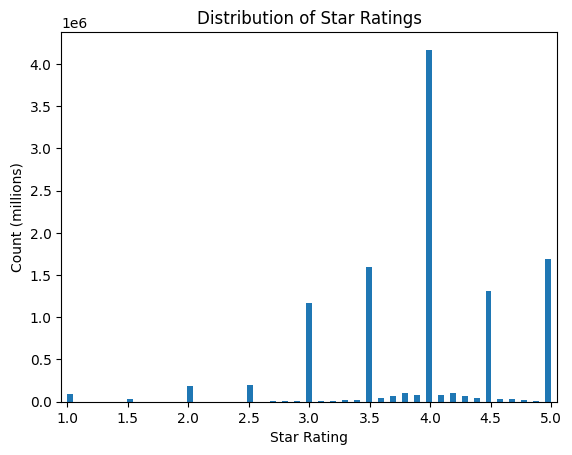

In [4]:
#| code-summary: "Code: get SQL table and plot ratings"
import matplotlib.pyplot as plt

q = """
SELECT rating
FROM vivino
;
"""
tbl = pd.read_sql(q, sql_address)

plt.hist(tbl['rating'], bins=81)
plt.xlabel('Star Rating')
plt.ylabel('Count (millions)')
plt.title('Distribution of Star Ratings')
plt.xlim(0.95,5.05)
plt.show()

There are reviews with low ratings! Here is a log-y plot.

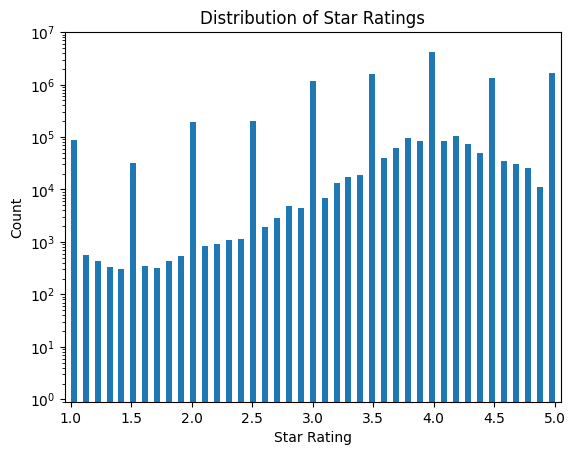

In [ ]:
#| code-summary: "Code: plot histogram of ratings"
plt.hist(tbl['rating'], bins=81, log=True)
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')
plt.ylim(0.9, 1e7)
plt.xlim(0.95,5.05)
plt.show()

Let's integrate the histogram to get a cumulative distribution.

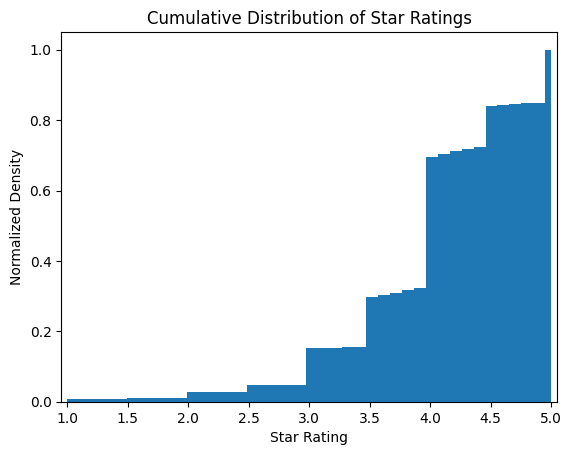

In [ ]:
#| code-summary: "Code: plot cumulative distribution of ratings"
plt.hist(tbl['rating'], bins=81, cumulative=True, density=True)
plt.xlabel('Star Rating')
plt.ylabel('Normalized Density')
plt.title('Cumulative Distribution of Star Ratings')
plt.xlim(0.95,5.05)
plt.show()

The above plots clearly show the ratings are distributed in a highly irregular fashion. 

Looks like less than 5% of bottles are rated below 3-stars. Why?

- Theory 1: Most bottles are decent or awesome.
- Theory 2: Low ratings are hidden... (unlikely)
- Theory 3: 3 stars is considered *bad*. 
- Theory 4: Bots. 
- Theory 5: There are more theories but I'm not a wine expert.

The answer is likely some combination of theories 1, 3, and 5. For instance, I would not expect many true 1-star wines to make it to market due to severe costs of production and self-destructive branding. Rather, 1-star ratings are likely from faulty/damaged bottling or storage, peculiar drinking preferences, or splitting[^1]. 

*Wine Spectator's* [100-point Scale](https://www.winespectator.com/articles/scoring-scale) gives credence to Theory 3. Anything below 50-pts or 3-stars is "Not recommended" and would be a devastating review. 

Note: I had no impression of Theory 4 until I dug a tiny bit deeper. There are a LOT of inexplicable behaviour that would surprise me if they were human. 

#### Average Rating per Wine 

The distribution of the average rating per wine shows a nice demonstration of the Central Limit Theorem. 

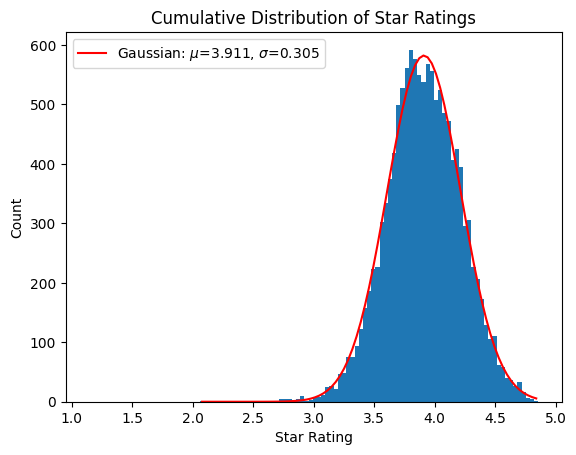

In [7]:
#| code-summary: "Code: plot histogram of average rating per wine"
from scipy.optimize import curve_fit
import numpy as np
def gaussian(x, mu, sigma, a):
    return a*np.exp(-0.5*(x-mu)**2/sigma**2)

q = """
SELECT AVG(rating) as avg_rating
FROM vivino
GROUP BY vivino_id
;
"""
tbl = pd.read_sql(q, sql_address)

h = plt.hist(tbl['avg_rating'], bins=81)

xdata = h[1][1:] - 0.5*np.diff(h[1])[0] #get center of edges.
ydata = h[0]
popt, pcov = curve_fit(gaussian, xdata, ydata, p0=(4, 0.5, 100))
plt.plot(xdata, gaussian(xdata, *popt), 
         'r-', 
         label=r'Gaussian: $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt[0:2]))

plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Cumulative Distribution of Star Ratings')
plt.xlim(0.95,5.05)
plt.legend()
plt.show()

## 3. Reviews

Let's look at the distribution of reviews per wine bottle. I use log-binning to capture the granularity of wines with few reviews. 

A log-normal distribution with a bit of skewness is a good description. These distributions appear normal when the x-axis is logscale. 

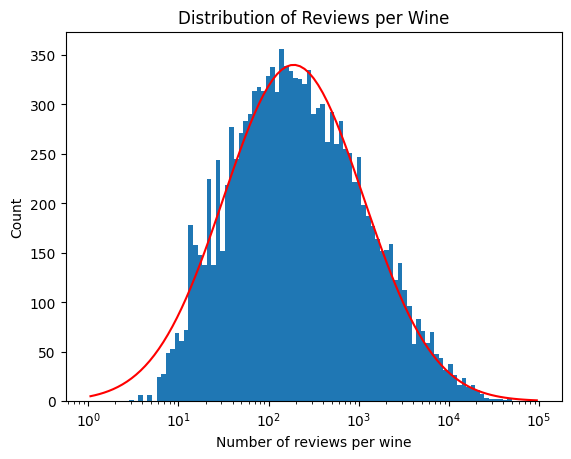

In [ ]:
#| code-summary: "Code: plot histogram of reviews per bottle"
q = """
SELECT count(*) as count
FROM vivino
GROUP BY vivino_id
;
"""
tbl = pd.read_sql(q, sql_address)

def lognormal(x, mu, sigma, a):
    return a*np.exp(-0.5*(np.log(x)-mu)**2/sigma**2) / (x * sigma)


h = plt.hist(tbl['count'], bins=np.logspace(np.log10(1),5, 100))

xdata = 10**(np.log10(h[1])[1:] - 0.5*np.diff(np.log10(h[1]))[0])
ydata = h[0]
popt, pcov = curve_fit(lognormal, xdata, ydata, p0=(250, 50, 100))
plt.plot(xdata, lognormal(xdata, *popt), 
         'r-', 
         label=r'Log-Normal: $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt[0:2]))


plt.xlabel('Number of reviews per wine')
plt.ylabel('Count')
plt.xscale('log')
plt.title(f'Distribution of Reviews per Wine')
plt.show()

Most wines have between 50 to 500 reviews each. The peak is at ~250 reviews per bottle. 

Earlier, I stated approximately 0.5% or 1-in-200 of reviews have price-sentiments (i.e., the reviews that I want). Let's say we need 10 price-sentiments to have an interesting signal. Then only bottles with 2,000+ reviews will likely the signal I desire. From the cumulative distribution below, that is approximately 15% of bottles. 

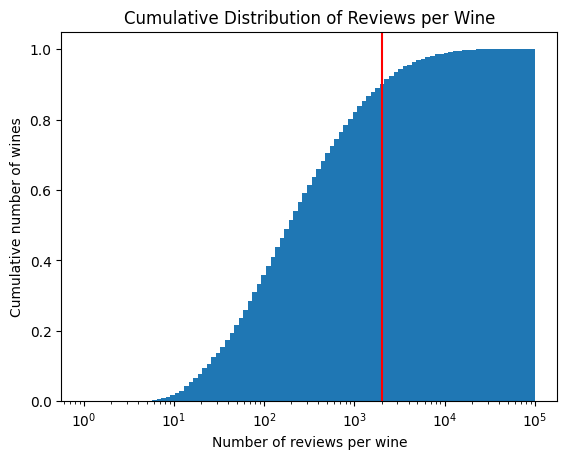

In [ ]:
#| code-summary: "Code: plot cumulative distribution of reviews per bottle"
h = plt.hist(tbl['count'], bins=np.logspace(np.log10(1),5, 100), cumulative=True, density=True)
plt.xlabel('Number of reviews per wine')
plt.ylabel('Cumulative number of wines')
plt.xscale('log')
plt.title(f'Cumulative Distribution of Reviews per Wine')
plt.axvline(2000, c = 'r')
plt.show()

The above figure is for the entire dataset which includes wines I am not able to purchase at my liquor store. If I exclude those wines, I find approximately 450 bottles purchasable at our liquor stores have over 2,000 reviews. This suggests there are plenty of purchasable wines to build a wine recommendation app based on price-sentiment. 

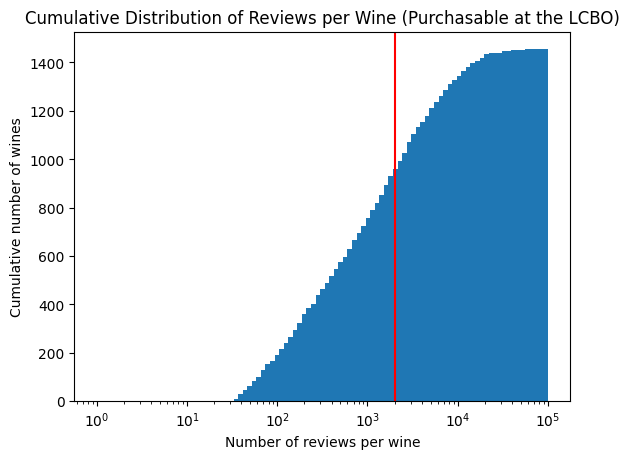

There are 1455 bottles available at the LCBO.


In [ ]:
#| code-summary: "Code: plot cumulative distribution of reviews per bottle from LCBO"
q = """
SELECT count(*)  FROM (
	SELECT vivid2 FROM (
		SELECT sku, vivid2 FROM index_matches
		WHERE sku IS NOT null
		AND vivid1 IS NOT null
		AND vivid2 IS NOT null
		) AS matches
	INNER JOIN (
		SELECT sku FROM inventory
		GROUP BY sku
	) AS buyable 
	ON matches.sku = buyable.sku
) AS buyable
LEFT JOIN (
	SELECT vivino_id FROM vivino
) AS vivino_reviews
ON vivid2 = vivino_id
GROUP BY vivino_id
"""

tbl = pd.read_sql(q, sql_address)

h = plt.hist(tbl['count'], bins=np.logspace(np.log10(1),5, 100), cumulative=True)
plt.xlabel('Number of reviews per wine')
plt.ylabel('Cumulative number of wines')
plt.xscale('log')
plt.title(f'Cumulative Distribution of Reviews per Wine (Purchasable at the LCBO)')
plt.axvline(2000, c = 'r')
plt.show()

print(f'There are {len(tbl)} bottles available at the LCBO.')

### Text

Our next goal is to study the review strings such as the word and character lengths. Let's grab a random set of 1 million reviews.

In [5]:
#| code-summary: "Code: get 1M random reviews"
import re
q = """
SELECT review_id, review, language FROM vivino
ORDER BY RANDOM()
LIMIT 1000000
"""
tbl = pd.read_sql(q, sql_address)
#delete more than one whitespace
tbl['review'] = tbl['review'].apply(lambda x: re.sub(' +', ' ', x))

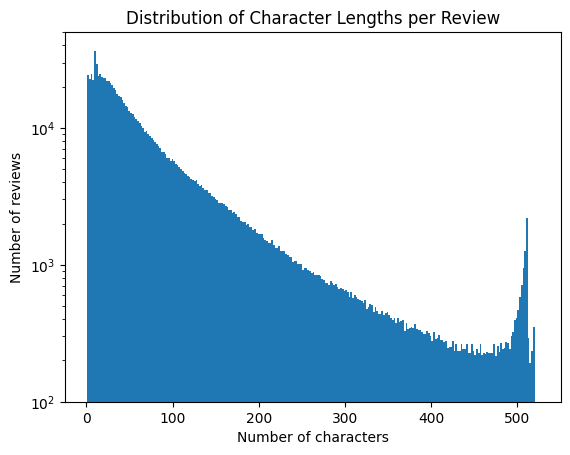

Example of a 500+ character review:
👁 Garnet red
👃 Cherry, raspberries and oak, the freshness is also very intense.
👅 Light body, well balanced, medium finish and very soft aftertaste, I didn’t feel the acidity which is characteristic of the Pinot Noirs, which gave me a good impresion of this wine! 

**Esp

👁 Rojo granate
👃 Cereza, frambuesa y roble, tambien senti una frescura intensa agradable
👅 Cuerpo ligero, bien equilibrado, final medio y retrogusto suave. No senti la acidez caracteristica de los Pinot Noir, lo cual me agrado bastante!





In [12]:
#| code-summary: "Code: plot histogram of character lengths"
import matplotlib.pyplot as plt
tbl['charLength'] = tbl['review'].apply(len)
plt.hist(tbl['charLength'], bins=int(max(tbl['charLength'])/2), log = True)
plt.title('Distribution of Character Lengths per Review')
plt.ylabel('Number of reviews')
plt.xlabel('Number of characters')
plt.ylim(1e2, 5e4)
plt.show()
print('Example of a 500+ character review:')
print(tbl[tbl['charLength']>=500]['review'].iloc[10])

Most users express write fewer than 100 characters. The users who express more appear as a spike in the distribution due to the 520 character limit. Very long reviews have a number of sentences and points. They often contain a story, lists of taste, smell, and sight descriptors, or common wine nomenclature (e.g., tannins, body, acidity). 


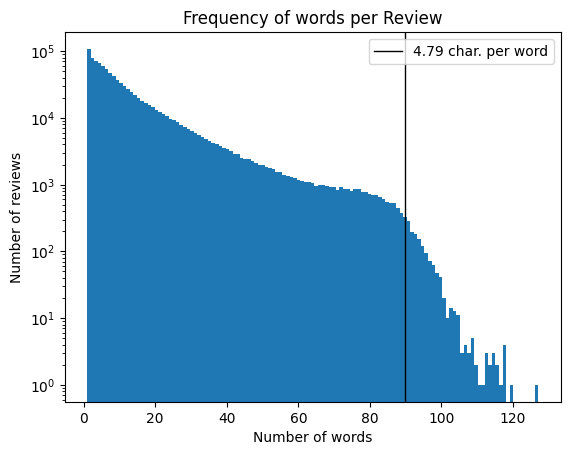

In [71]:
#| code-summary: "Code: plot histogram of word lengths"
#| label: fig-words
#| fig-cap: Frequency of words in reviews
tbl['wordLength'] = tbl['review'].apply(lambda x: len(x.split(' ')))
plt.hist(tbl['wordLength'], bins=int(max(tbl['wordLength'] )), log = True)
plt.title('Frequency of words per Review')
plt.ylabel('Number of reviews')
plt.xlabel('Number of words')
plt.axvline(520/5.79, c = 'k', lw=1, label = "4.79 char. per word")
plt.legend()
plt.show()

A study of google books found that the average number of characters per word is 4.79 ([Norvig](http://norvig.com/mayzner.html)). White spaces are counted in the character limit of reviews, so the average word approximately occupies 5.79 characters. The maximum number of average words in 520 characters is then 520 / 5.79 ~ 90 words, which is located at the knee in the distribution!

Let's plot see how the character and word lengths are distributed together.

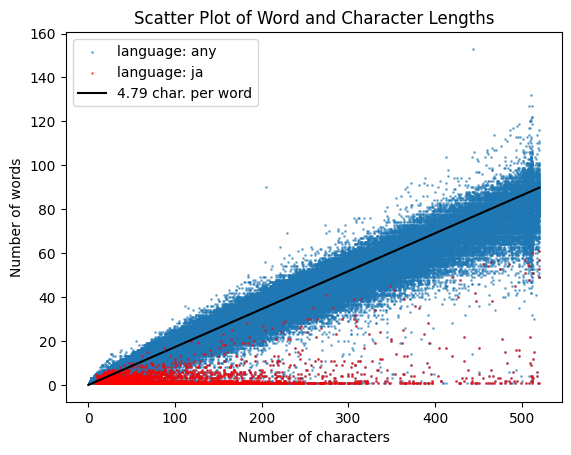

In [114]:
#| code-summary: "Code: plot character and word lengths"
plt.scatter(tbl['charLength'], tbl['wordLength'], s= 1, alpha=0.5, label='language: any')
plt.scatter(tbl[tbl['language']==ja]['charLength'], tbl[tbl['language']==ja]['wordLength'], c = 'r', s= 1, alpha=0.5, label='language: ja')
plt.title('Scatter Plot of Word and Character Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Number of words')
plt.plot([0,520], [0, 520/5.79], c = 'k', label = "4.79 char. per word")
plt.legend()
plt.show()

There are clearly two sets of distributions. The dominant diagonol distribution shows most reviews contain 4.79 characters (plus 1 white space) per word, no matter the review length! 

The smaller distribution of reviews with a very high character-word density are either written in kanji, have numerous emojis, or are just riiiiiiiiiiiiiiiiiiidiculously long:

In [118]:
#| echo: false 
print(tbl[(tbl['charLength']>=500) & (tbl['wordLength']<10)]['review'].iloc[0:20])

28362     ソライア2009\nTENUTA TIGNANELLO (ANTINORI)\nテヌータ・テ...
34597     Para comprar a cajas....\n\n\n👏👏👏👏👏👏👏👏👏👏👏👏👏\n🍷...
146622    ブレッドアンドバター、ピノノワール2021年\n\nカリフォルニア、ナパヴァレーの人気ワイナ...
166770    Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
222111    Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
234564    Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
245968    SONOMA COAST LES NOISETIERS CHARDONNAY 2019\n\...
271508    3,75*\n\nBuena RCP\n\n\n👏👏👏👏👏👏👏👏👏👏👏👏👏\n🍷🍷🍷🍷🍷🍷🍷...
306546    Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
320458    Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
324681    サヴォワ・アプルモン・キュヴェ・ガストロノミー 2019\n\n淡いライトグリーン。ゆったり...
335071    持って来てくれた人曰くオレンジワインらしい。\n\n外観はオレンジ色がかった強目の黄色からゴ...
394920    ユニオン・デ・グラン・クリュ・ド・ボルドーにて。\n2019ヴィンテージ。\n\n去年の20...
400628    グラハム・ベック・ブリュット・ロゼ NV\n\n少し紫がかった濃いピンク。決め細かな泡立ち。...
401848    シャトー アンジェリュス\n2018.2017.2014\n\n2018、濃い紫寄りのガーネ...
504967    自宅にて開栓。\n2015ヴィンテージ。\n\n家で2016ヴィンテージを飲んで気に入ったシ...
542056    T持ち込みワイン会にて。\n2015ヴィンテージ。\n\n自

Hmm... There's one user who enjoys writing reviews with very low information density. 

In [128]:
#| code-summary: "Code: get number of duplicate reviews from francisco_silva6"
tmpID = 355128697
q = f""" 
SELECT count(*)
FROM vivino 
WHERE review = (
    SELECT review
    FROM vivino
    WHERE review_id = {tmpID}  
)
AND user_seo_name='francisco_silva6' 
--the name condition makes no difference
"""
tbl_gra = pd.read_sql(q, sql_address)
print(f'Number of duplicates: {tbl_gra["count"].iloc[0]}')
tbl[tbl['review_id']==tmpID]['review'].iloc[0]


Number of duplicates: 131


'Graaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaande vinho'

Wow. 131 duplicates! Lots of questions. This is a good opportunity to talk about Vivino's users. 

## 4. Users

### Likes and Comments

Here are histograms for the number of likes and comments for a review.  

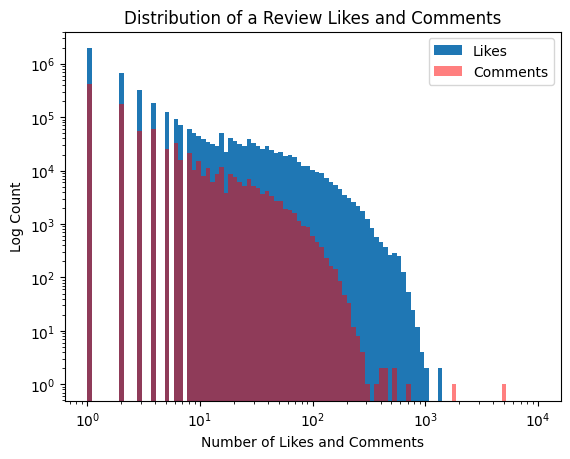

In [ ]:
#| code-summary: "Code: plot histogram of likes and comments per review"
import math

q = """
SELECT likes_count, comments_count
FROM vivino
;
"""
tbl = pd.read_sql(q, sql_address)

binWidth = 20
maxBinsLikes = int(math.ceil(max(tbl['likes_count'])/binWidth)+1)*binWidth
maxBinsComments = int(math.ceil(max(tbl['comments_count'])/binWidth)+1)*binWidth
rangeBinsLikes = range(0,maxBinsLikes, binWidth)
rangeBinsComments = range(0,maxBinsComments, binWidth)

plt.hist(tbl['likes_count'], bins=np.logspace(np.log10(1),4, 100), log=True, label="Likes")
plt.hist(tbl['comments_count'], bins=np.logspace(np.log10(1),4, 100), log=True, alpha=0.5, color = 'r', label="Comments")
plt.xlabel('Number of Likes, and Comments')
plt.ylabel('Log Count')
plt.title('Distribution of a Review Likes and Comments')
plt.xscale('log')
plt.legend()
plt.show()

From experience, it makes sense that there are fewer comments than likes[^2] and that most reviews do not have many likes. There are ~100 reviews that have over 500 likes, which is impressive. Here are a few samples:

In [77]:
#| echo: false

q = """
SELECT review
FROM vivino
WHERE likes_count > 500
AND language = 'en'
;
"""
tbl = pd.read_sql(q, sql_address)
for s in tbl.sample(n=3)['review']:
    print(s + '\n--------------------------------')

Splendid Umbrian blend of 70% Merlot, 20% CS and 10% CF, originating from vineyards located on the Spello and Assisi hills, aged for 12m in French barriques and another 24m in the bottle.  
Inky dark red, displaying scents of blueberries, blackberries, laurel, sweet almonds, smoky cedar and bitter dark chocolate refined with a whiff of mint.  
Despite its age still very grippy, showing firm tannins that structure a dense core of  fresh and juicy dark fruit with clear hints of pepper in the finisch.  
4.0*
--------------------------------
⭐️ 90 P/ 4.0* Very nice aged Tawny Port. Typical for the style, with a good complexity and concentration. Can stand alone or with food (e.g. cheese).
 
👁 Pale tawny.
 
👃 Intense nose of tertiary flavors – raisins, tobacco, leather, cedar, roasted nuts, milk chocolate, butterscotch, rum infused berries, dates, cooked red and black berries.
 
👅 Half-sweet with a med+ acidity. High in alcohol with med and ripe tannins. The body is med+. The finish is domi

### Bots?

It is shocking that there are reviews with more than a few hundred comments! That sounds busier than a controversial tweet. How can a review have over 2000 or 5000 comments?? Let's take a peek.

In [103]:
#| code-summary: "Code: select reviews with over 400 comments"
q = """
SELECT comments_count as comments, likes_count as likes, review, user_seo_name as name, user_followers_count as followers, user_followings_count as followings
FROM vivino
WHERE comments_count > 400
ORDER BY comments_count
;
"""
tbl = pd.read_sql(q, sql_address)
tbl

,comments,likes,review,name,followers,followings
0,405,205,"They say you will always remember your first, ...",kelley_do,5997,2042
1,411,13,Schäumig wie‘s sein soll. Ansonsten sehr üppig...,luigi.pietronello,102,254
2,433,3,Wawww,ademar.ju,57,57
3,446,234,Rich modern style that incorporates classic Ri...,akarter,5886,147
4,520,1,Good wine!,alessandra.fag,14,20
5,547,514,"A fantastic Syrah, deep black color, deep anim...",scorewine,16646,242
6,676,4,"Vin blanc très sucré, véritablement de l'or en...",alexandre.yi,37,31
7,1848,0,Very very Nice amarone. Fruitful and full with...,m58cb20b86fe892ae6f5543f9e9b2c8c,0,0
8,5073,0,Very very nice sauternes.,m58cb20b86fe892ae6f5543f9e9b2c8c,0,0


Weird! It looks like **m58cb20b86fe892ae6f5543f9e9b2c8c** is a bot or experiment. Their [profile](https://www.vivino.com/users/m58cb20b86fe892ae6f5543f9e9b2c8c) shows some reviews with over 5,000 comments and zero likes. Here are comments for one of them:

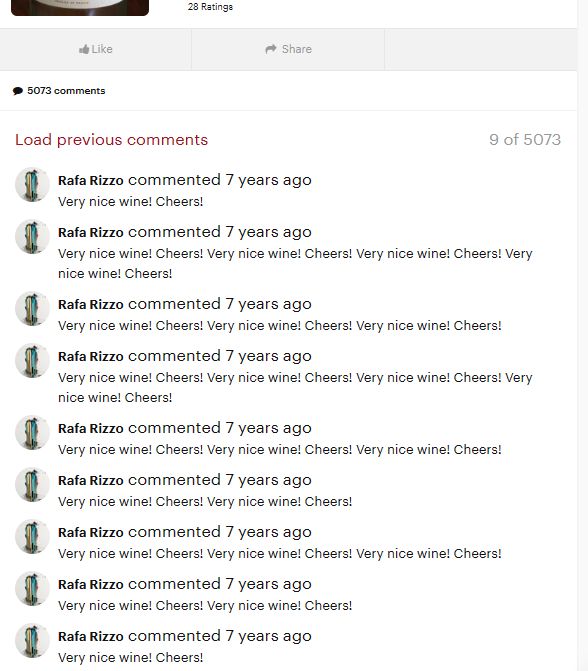

User [**ademar.ju**](https://www.vivino.com/users/ademar.ju) has reviewed 24 bottles which have single-digit likes, hundreds of comments each, all of which are written by **Leonel de Paula**. [Leonel de Paula](https://www.vivino.com/users/leonel.de-paula) also comments on their own wine reviews with emojis, and tags other users. 

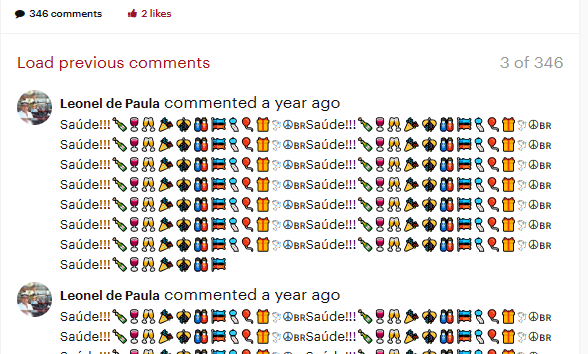

Some users like **[kelley_do](https://www.vivino.com/users/kelley_do)** and **[scorewine](https://www.vivino.com/users/scorewine)** appear to be real people with strong passions for wine. 

There is a lot more I can say about these bots on Vivino that I will say in my next blog post. For now, I do not find any reviews from suspected bots with prices in them. This suggests that my work on price-sentiments is unlikely to suffer from bots generating fake reviews. 

### Vivino Users

There are five numeric features for each user:

1. Followers: People who follow the user.
2. Followings[^3]: People who the user follows. 
3. Ratings count: Total number of ratings from the user.
4. Ratings sum: Sum of all of user's ratings.
5. Reviews count: Total number of reviews authored from the user. 

#### User connections:

Let's see how reviewers are connected to their communities. 

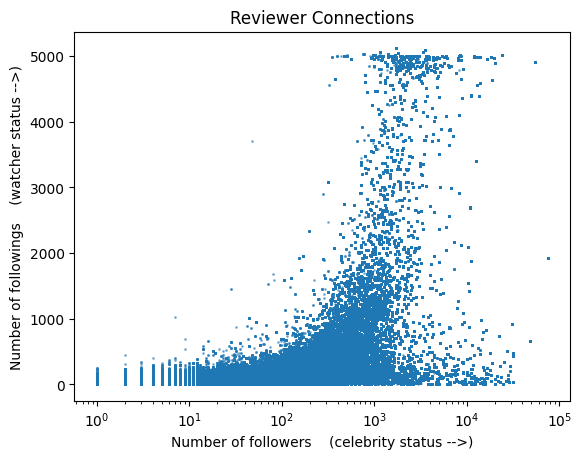

In [37]:
#| code-summary: "Code: plot followers vs. participation"
q = """ 
SELECT user_followers_count, user_followings_count
FROM vivino 
"""
tbl = pd.read_sql(q, sql_address)

plt.scatter(tbl['user_followers_count'], tbl['user_followings_count'], s= 1, alpha=0.5)
plt.title('Reviewer Connections')
plt.xlabel('Number of followers    (celebrity status -->)')
plt.ylabel('Number of followings    (watcher status -->)')
plt.xscale('log')
plt.show()

Wow! There's a peculiar vase distribution. First, there's some sort of uneven cap on the maximum number of people a reviewer can follow. The massive void on the left is striking and the reason is unclear just from this data. At the very least, it shows that you might be able to make connections just by following people. There is a lot of structure here that I will try to dig deeper in another post.

#### Participation

Let's define a crude participation metric that equals the number of reviews authored plus ratings given. Then, plot this against the number of followers. (Yes, the results inherently ignore all Vivino users who do not write reviews). 

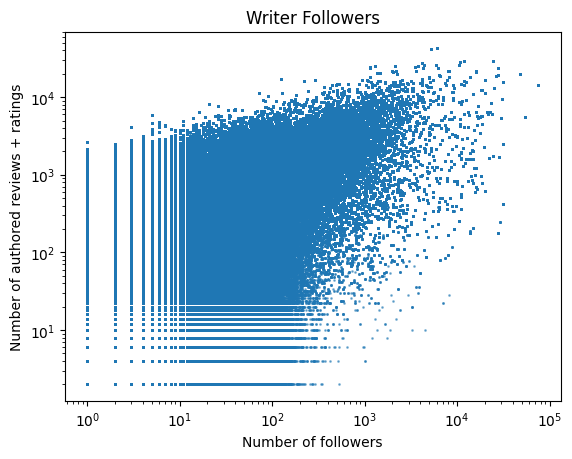

In [53]:
#| code-summary: "Code: plot followers vs. participation"
q = """ 
SELECT user_followers_count, user_followings_count, user_reviews_count, user_ratings_count, user_seo_name
FROM vivino 
"""
tbl = pd.read_sql(q, sql_address)

plt.scatter(tbl['user_followers_count'], tbl['user_reviews_count']+tbl['user_reviews_count'], s= 1, alpha=0.5)
plt.title('Writer Followers')
plt.xlabel('Number of followers')
plt.ylabel('Number of authored reviews + ratings')
plt.xscale('log')
plt.yscale('log')
plt.show()

There is a loose correlation between a user's participation in reviews and ratings, and their follower count. My attention is drawn to the bottom where users have huge followings and participate very little. Let's look at some of them:

In [129]:
q = """ 
SELECT user_followers_count as followers, user_followings_count as followings, user_ratings_count as ratings, user_reviews_count as reviews, user_seo_name as username
FROM vivino 
WHERE user_reviews_count + user_ratings_count <= 4
AND user_followers_count > 200
ORDER BY user_followers_count
"""
tbl_bot = pd.read_sql(q, sql_address)
tbl_bot

,followers,followings,ratings,reviews,username
0,210,409,1,1,roberto.campane
1,218,224,2,2,m7748f668dbdc131b7330298a3f91cb3
2,228,63,2,1,eduardo_silves
3,267,0,1,1,gabriel-moo
4,287,257,2,2,junior-ma
5,292,517,1,1,m778d4a83c4adc3c41786c1a8f45d28a
6,300,293,2,2,eva_bel
7,528,85,1,1,tino.ma


Ah ha! The mysterious **m7748f668dbdc131b7330298a3f91cb3** users. 

#### Usernames

I suspect the number of bots to be quite high. But, this is quite difficult to determine definitively without access to a user's detailed logs. A potential gauge is number of characters in a username. 

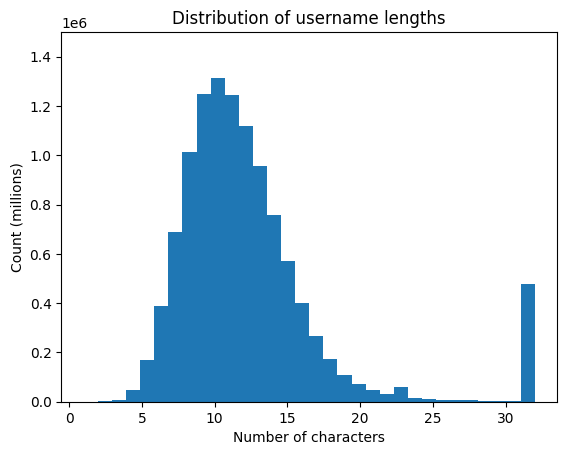

In [236]:
#| echo: false
q = """ 
SELECT user_followers_count as followers, user_followings_count as followings, user_reviews_count as num_reviews,  user_ratings_count as num_ratings, user_seo_name as username
FROM vivino 
"""
tbl = pd.read_sql(q, sql_address)

tbl['len_name'] = tbl['username'].apply(len)
bins = max(tbl['len_name'] )

plt.hist(tbl['len_name'], bins = bins)

plt.xlabel('Number of characters')
plt.ylabel('Count (millions)')
plt.title('Distribution of username lengths')
plt.ylim(0,1.5e6)
plt.show()

Woah! I wasn't expecting a sizable number of users have the max length for usernames. Let's take a look at some of the names.

In [235]:
#| echo: false
tbl31 = tbl[tbl['len_name']==31].sample(n=5)
tbl32 = tbl[tbl['len_name']==32].sample(n=10)
pd.concat([tbl31, tbl32])

,followers,followings,num_reviews,num_ratings,username,len_name
2074247,0,0,11,12,edu.gaytan.eduardo101-gmail.com,31
1177568,74,20,874,919,university-of-bath.wine-society,31
8325228,0,5,13,13,jael.patricia-granados-kraulles,31
8796594,7,7,261,262,danton-cavalcanti.franco-junior,31
3811532,1,0,36,38,marc-antoine.mailloux-labrousse,31
1067813,5,5,64,64,b7941e714811716b34fec5f91046cae2,32
6142637,4,2,6,7,d0a0d35afcfa00b39219856348c1cb12,32
10306389,52,28,1274,1303,m276c28ed28bdf63ac70599392739db6,32
340985,6,8,19,23,m4a610a084aeb6643b624f19501e5dbc,32
8049959,393,105,312,312,m2210f2e3d21d5f526d8119fae5b94bd,32


Ah. The 32-char names appear to be hashes. Some of these accounts appear legitimate. The backgrounds in their photos of wine appear to be the same environment for some users. It seems like a coincidence that the user with 5,000 comments on their reviews has the hash-like username. 

## Wine Notes

Reviewers list the 'notes' of wine in their reviews. A nice surprise found in this data is a list of notes identified by Vivino. There are many, many notes. 

Number of distinct notes: 456


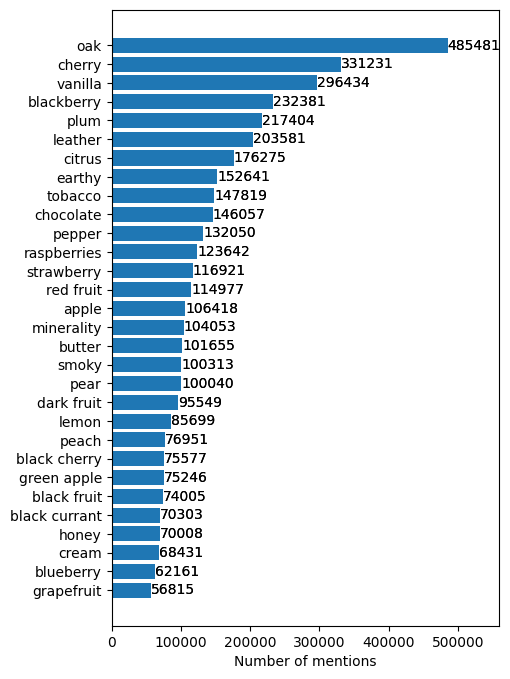

In [14]:
#| echo: false
from collections import Counter
from collections import ChainMap
from itertools import chain

q = """ 
SELECT flavors
FROM vivino
WHERE flavors is not NULL
"""
tbl = pd.read_sql(q, sql_address)

notesDict = tbl['flavors'].apply(lambda row: {x['id']:x['match'] for x in row})
notesDict = dict(ChainMap(*notesDict))

notes = list(tbl['flavors'].apply(lambda row: [x['id'] for x in row]))
notes = list(chain(*notes))
notesCount = dict(Counter(notes))

print(f'Number of distinct notes: {len(notesCount)}')

notesCount_sorted = dict(sorted(notesCount.items(), key=lambda item: item[1]))

numDisplay = 30
labels = [notesDict[k] for k in notesCount_sorted.keys()]
values = list(notesCount_sorted.values())

fig, ax = plt.subplots(1,1, figsize=(5,8))
bars = ax.barh(labels[-numDisplay:], values[-numDisplay:])

ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
    
ax.set_xlim(0, 560000)
ax.set_xlabel('Number of mentions')
plt.show()

# Next Steps

My next blogs will be about wine reviews and...

- Bots!
- Reviews with price-sentiment
- Machine learning and sentence transformers
- Unsupervised topic modeling

Thank you for reaching the end! 

[^1]: people who think black and white, or 1- and 5-stars only.
[^2]: because effort
[^3]: Vivino needs to use a different word for followings.